# Prepare environment

In [96]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

# Any results you write to the current directory are saved as output.

In [97]:
!pip install albumentations --user > /dev/null 2>&1

In [98]:
!pip install pretrainedmodels --user > /dev/null 2>&1

In [99]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

from collections import OrderedDict
import cv2
import albumentations
from albumentations import torch as AT
import pretrainedmodels
import csv
from torchvision import models

In [100]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Prepare data

In [101]:
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/new_whale_test.csv")
train_df.head()

,Image,Id
0,b4284d5ef.jpg,w_16b5050
1,4b82a9fc0.jpg,new_whale
2,16bf136fb.jpg,w_e73cce3
3,9805abc71.jpg,w_d6fde02
4,4e2803603.jpg,w_83a4279


In [102]:
print(f"There are {len(os.listdir('../data/train'))} images in train dataset with {train_df.Id.nunique()} unique classes.")
print(f"There are {len(os.listdir('../data/test'))} images in test dataset with {test_df.Id.nunique()} unique classes.")
    

There are 20288 images in train dataset with 4571 unique classes.
There are 5074 images in test dataset with 1522 unique classes.


In [103]:
train_df.Id.value_counts().head()

new_whale    7728
w_23a388d      60
w_9b5109b      55
w_0369a5c      54
w_9c506f6      52
Name: Id, dtype: int64

In [104]:
for i in range(1, 4):
    print(f'There are {train_df.Id.value_counts()[train_df.Id.value_counts().values==i].shape[0]} classes with {i} samples in train data.')

There are 2182 classes with 1 samples in train data.
There are 1085 classes with 2 samples in train data.
There are 441 classes with 3 samples in train data.


In [105]:
len(train_df.Id)

20288

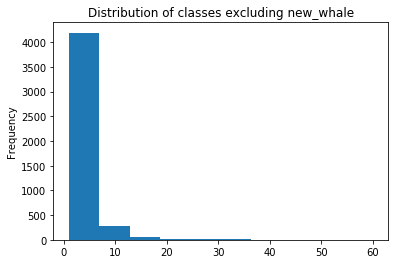

In [106]:
train_df.Id.value_counts()[1:].plot(kind='hist');
plt.title('Distribution of classes excluding new_whale');

In [107]:
def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

In [108]:
y, le = prepare_labels(train_df['Id'])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


# Prepare Network

### Simple CNN

In [137]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx - 1][0])
            label = self.y[idx - 1]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx - 1])
            label = np.zeros((4571,))

        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]
        

In [138]:
data_transforms = transforms.Compose([
                                      transforms.Resize((100, 100)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
data_transforms_test = transforms.Compose([
                                           transforms.Resize((100, 100)),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])
])


In [139]:
train_dataset = WhaleDataset(datafolder='../data/train/', datatype='train', df=train_df, transform=data_transforms, y=y)
test_set = WhaleDataset(datafolder='../data/test/', datatype='test', transform=data_transforms_test)

train_sampler = SubsetRandomSampler(list(range(len(os.listdir('../data/train')))))
valid_sampler = SubsetRandomSampler(list(range(len(os.listdir('../data/test')))))
batch_size = 128
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
# less size for test loader.
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=num_workers)


In [140]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 7, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)        
        self.pool2 = nn.AvgPool2d(3, 3)
        
        self.fc1 = nn.Linear(64 * 4 * 4 * 16, 1024)
        self.fc2 = nn.Linear(1024, 4571) # todo

        self.dropout = nn.Dropout(0.5)        

    def forward(self, x):
        x = self.pool(F.relu(self.conv2_bn(self.conv1(x))))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 4 * 4 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [141]:
model_conv = Net()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_conv.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Resnet 18

In [115]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx - 1][0])
            label = self.y[idx - 1]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx - 1])
            label = np.zeros((4571,))

        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]
        

In [116]:
data_transforms = transforms.Compose([
                                      transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
data_transforms_test = transforms.Compose([
                                           transforms.RandomResizedCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])
])


In [117]:
train_dataset = WhaleDataset(datafolder='../data/train/', datatype='train', df=train_df, transform=data_transforms, y=y)
test_set = WhaleDataset(datafolder='../data/test/', datatype='test', transform=data_transforms_test)

train_sampler = SubsetRandomSampler(list(range(len(os.listdir('../data/train')))))
valid_sampler = SubsetRandomSampler(list(range(len(os.listdir('../data/test')))))
batch_size = 32
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
# less size for test loader.
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=num_workers)


### useful

In [118]:
num_classes = 4571
model_conv = models.resnet18(pretrained=True)
num_ftrs = model_conv.fc.in_features #最后fc层的输入
model_conv.fc = nn.Linear(num_ftrs, num_classes) #NUM_CLASSES是自己数据的类别
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_conv.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


# Transfer Learning

### Run this before TRAIN

In [113]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform

    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx - 1][0])
            label = self.y[idx - 1]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx - 1])
            label = np.zeros((4571,))

        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = self.transform(image=img)
        image = image['image']
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]

In [114]:
data_transforms = albumentations.Compose([
    albumentations.Resize(160, 320),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightness(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.JpegCompression(80),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])
data_transforms_test = albumentations.Compose([
    albumentations.Resize(160, 320),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

train_dataset = WhaleDataset(datafolder='../data/train/', datatype='train', df=train_df, transform=data_transforms, y=y)
test_set = WhaleDataset(datafolder='../data/test/', datatype='test', transform=data_transforms_test)

train_sampler = SubsetRandomSampler(list(range(len(os.listdir('../data/train')))))
valid_sampler = SubsetRandomSampler(list(range(len(os.listdir('../data/test')))))
batch_size = 10
num_workers = 0
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
#valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10, num_workers=num_workers)


In [52]:
model_conv = pretrainedmodels.resnext101_64x4d()
model_conv.avg_pool = nn.AvgPool2d((5,10))
model_conv.last_linear = nn.Linear(model_conv.last_linear.in_features, 4571)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/resnext101_64x4d-e77a0586.pth" to /datasets/home/48/248/k7wang/.cache/torch/checkpoints/resnext101_64x4d-e77a0586.pth
  0%|          | 786432/334703243 [00:02<16:54, 329115.97it/s] 


KeyboardInterrupt: 

In [ ]:
model_conv.cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_conv.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Train

### Every model use the same one

In [ ]:
model_conv.cuda()
n_epochs = 10
acc = [0] * (n_epochs + 1)
total = list(0. for i in range(train_df.Id.nunique()))
correct = list(0. for i in range(train_df.Id.nunique()))
llloss = [0] * (n_epochs + 1)

for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)

    train_loss = []
    valid_loss = []
    exp_lr_scheduler.step()
    accuracy = []
    
    # train
    for batch_i, (data, target) in enumerate(train_loader):
        #print(batch_i)
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model_conv(data)
        predicted = torch.argmax(output, 1)

        res = (predicted == torch.argmax(target, 1)).squeeze()
        
        for label_idx in range(len(target)):
            
            label_single = torch.argmax(target, 1)[label_idx]
            correct[label_single] += res[label_idx].item()
            total[label_single] += 1
        
        loss = criterion(output, target.float())
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
          
    llloss[epoch] = np.mean(train_loss)
    acc[epoch] = sum(correct)/sum(total)
    print(f'Epoch {epoch}, train loss: {llloss[epoch]}, acc : {acc[epoch]}')
    
acc_base_train = acc
loss_base_train = llloss

Sat Jun  8 14:31:08 2019 Epoch: 1
Epoch 1, train loss: 0.012598100320418488, acc : 0.35227720820189273
Sat Jun  8 14:35:38 2019 Epoch: 2
Epoch 2, train loss: 0.0020184835796859465, acc : 0.3665713722397476
Sat Jun  8 14:40:10 2019 Epoch: 3
Epoch 3, train loss: 0.0018078331797495015, acc : 0.371352523659306
Sat Jun  8 14:44:42 2019 Epoch: 4
Epoch 4, train loss: 0.0017724444777792636, acc : 0.3737430993690852
Sat Jun  8 14:49:15 2019 Epoch: 5
Epoch 5, train loss: 0.0017658993894667746, acc : 0.3751774447949527
Sat Jun  8 14:53:45 2019 Epoch: 6
Epoch 6, train loss: 0.001735927807255033, acc : 0.37613367507886436
Sat Jun  8 14:58:20 2019 Epoch: 7
Epoch 7, train loss: 0.0017306901655107173, acc : 0.3768166967102298
Sat Jun  8 15:02:52 2019 Epoch: 8


In [ ]:
net_name = 'Simple_cnn'

In [ ]:
torch.save(model_conv.state_dict(), net_name + '.pth')
#model_conv.load_state_dict(torch.load(net_name + '.pth'))

### Plot

In [ ]:
acc_base_train = acc
loss_base_train = llloss

In [ ]:

epoch = range(1, 5)
plt.plot(epoch, acc_base_train[1:5], label = 'Accuracy')

plt.xlabel('Epoch')
plt.title(net_name + ' ACC')
plt.legend()
plt.savefig(f'../result/{net_name}_ACC_{time.ctime()}.jpg')#,dpi = 900)
plt.show()

In [ ]:
plt.plot(epoch, loss_base_train[1:5], label = 'Loss')
plt.xlabel('Epoch')
plt.title(net_name + ' LOSS')
plt.legend()
plt.savefig(f'../result/{net_name}_LOSS_{time.ctime()}.jpg')#,dpi = 900)
plt.show()

### Get test result

In [79]:
ext_1 = []
ext_2 = []
#for (data, target, name) in train_loader:
for batch_i, (data, target) in enumerate(train_loader):
    if batch_i == 2000:
        break
    print(f'exctrating data in batch{batch_i}')
    data = data.cuda()
    model_conv.cuda()
    output = model_conv(data)
    for i in range(len(output)):
        ext_1.append((output[i].cpu().detach().numpy(),target[i]))
        ext_2.append((data[i].cpu().detach().numpy(),target[i]))

exctrating data in batch0
exctrating data in batch1
exctrating data in batch2
exctrating data in batch3
exctrating data in batch4
exctrating data in batch5
exctrating data in batch6
exctrating data in batch7
exctrating data in batch8
exctrating data in batch9
exctrating data in batch10
exctrating data in batch11
exctrating data in batch12
exctrating data in batch13
exctrating data in batch14
exctrating data in batch15
exctrating data in batch16
exctrating data in batch17
exctrating data in batch18
exctrating data in batch19
exctrating data in batch20
exctrating data in batch21
exctrating data in batch22
exctrating data in batch23
exctrating data in batch24
exctrating data in batch25
exctrating data in batch26
exctrating data in batch27
exctrating data in batch28
exctrating data in batch29
exctrating data in batch30
exctrating data in batch31
exctrating data in batch32
exctrating data in batch33
exctrating data in batch34
exctrating data in batch35
exctrating data in batch36
exctrating 

In [86]:
dim_output = 1522
x = np.zeros((len(ext_1), dim_output))
y_n = np.zeros(len(ext_1))
for i in range(len(ext_1)):
    x[i, :] = ext_1[i][0].reshape(1, dim_output)
    y_n[i] = np.argmax(ext_1[i][1].cpu().detach().numpy(), axis = 0)
x_ts = np.zeros((len(test_ext_1), dim_output))
y_n_ts = np.zeros((len(test_ext_1)))
for i in range(len(test_ext_1)):
    x[i, :] = test_ext_1[i][0].reshape(1, dim_output)
    y_n_ts[i] = np.argmax(test_ext_1[i][1].cpu().detach().numpy(), axis = 0)

ValueError: cannot reshape array of size 4571 into shape (1522,)

In [48]:
sub = pd.read_csv('../data/sample_submission.csv')

model_conv.eval()
for (data, target, name) in test_loader:
    data = data.cuda()
    output = model_conv(data)
    output = output.cpu().detach().numpy()
    for i, (e, n) in enumerate(list(zip(output, name))):
        sub.loc[sub['Image'] == n, 'Id'] = ' '.join(le.inverse_transform(e.argsort()[-5:][::-1]))
        
sub.to_csv(f'../result/submission_RES18_{time.ctime()}.csv', index=False)